# Latent Processing Analysis

This notebook performs a latent processing analysis on the latent space of the MaxP5_3 autoencoder.

In [ ]:
import base64
from PIL import Image
import io
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap
import hdbscan
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from facesim3d import local_paths

output_dir = local_paths.DIR_PCA_AE_RESULTS_MaxP

# Load latent space and image paths
latents = np.load(os.path.join(output_dir, "latent_codes_MaxP.npy"))  # shape: (n_samples, latent_dim)
print(f"Loaded {latents.shape[0]} latent vectors with shape {latents.shape}.")

Loaded 161700 latent vectors with shape (161700, 32).


In [ ]:
paths = np.load(os.path.join(output_dir, "image_paths_MaxP.npy"), allow_pickle=True)  # list of image file paths
print(f"Example image path: {paths[0]}")

# extract filename base for matching it with metadata
def extract_base(p):
    base = os.path.basename(p)
    # Convert .png to .npy since metadata heatmap_file column stores .npy
    if base.endswith(".png"):
        base = base.replace(".png", ".npy")
    return base

path_bases = [extract_base(p) for p in paths]
print(f"Example base image path: {path_bases[0]}")

Example image path: /work/lg77sypy-create_AE_training_data/scripts/single_LRP_MaxP_heatmaps_pred_ID/single_heatmaps/triplet122910_pred_head037.png
Example base image path: triplet122910_pred_head037.npy


In [ ]:
metadata_folder = local_paths.DIR_SINGLE_MaxP_HEATMAPS
meta = pd.read_csv(os.path.join(metadata_folder, "single_heatmaps_metadata.csv"))     # must match order of latents
meta.head()

In [4]:
# add head id column:
head_cols = ["head1", "head2", "head3"]

# Convert the 3 head columns to a numpy array of shape (N, 3)
heads = meta[head_cols].to_numpy()        # shape: (N, 3)

# model_pred contains integers 0,1,2 → use as column index
pred = meta["model_pred"].to_numpy()      # shape: (N,)

# Gather the correct head per row
meta["head_index"] = heads[np.arange(len(meta)), pred]
meta.head()

dataset_idx  head1  head2  head3  gt_odd_head  model_pred  \
0        76234     18     82     90           90           1   
1       150660     58     71     98           71           1   
2        46900     10     49     89           10           1   
3       149733     57     68     78           57           0   
4        98214     26     48     85           85           2   

   human_choice_index  correct                    heatmap_file  head_index  
0                   2        0   triplet76234_pred_head082.npy          82  
1                   1        1  triplet150660_pred_head071.npy          71  
2                   0        0   triplet46900_pred_head049.npy          49  
3                   0        1  triplet149733_pred_head057.npy          57  
4                   2        1   triplet98214_pred_head085.npy          85

In [5]:
# align meta with the order of latents
meta = meta.set_index("heatmap_file").loc[path_bases].reset_index()
meta.head()

heatmap_file  dataset_idx  head1  head2  head3  \
0  triplet122910_pred_head037.npy       122910     37     55     76   
1   triplet83384_pred_head021.npy        83384     21     32     71   
2  triplet106536_pred_head082.npy       106536     29     70     82   
3   triplet90575_pred_head095.npy        90575     23     58     95   
4  triplet160194_pred_head095.npy       160194     78     80     95   

   gt_odd_head  model_pred  human_choice_index  correct  head_index  
0           37           0                   0        1          37  
1           21           0                   0        1          21  
2           82           2                   2        1          82  
3           95           2                   2        1          95  
4           95           2                   2        1          95

In [6]:
# Normalize latent vectors
scaler = StandardScaler()
latents_scaled = scaler.fit_transform(latents)

In [ ]:
reducer = umap.UMAP(n_components=2, random_state=42)
#latents_2d = reducer.fit_transform(latents_scaled)
#np.save(os.path.join(output_dir, "latent_UMAP_AE_MaxP.npy"), latents_2d)

In [ ]:
import numpy as np 

# Load again once calculated
latents_2d = np.load(os.path.join(output_dir, "latent_UMAP_AE_MaxP.npy"))
print('Loaded UMAP representations')

Loaded UMAP representations


## Visualization

In [8]:
# map each head ID to the corresponding path using the meta data
# Extract head IDs from meta dataframe
head_ids = []
for idx, row in meta.iterrows():
    # Get the predicted head ID using model_pred index
    pred_index = int(row['model_pred'])
    
    # Extract head columns (head1, head2, head3)
    head_columns = ['head1', 'head2', 'head3']
    head_id = row[head_columns[pred_index]]
    head_ids.append(head_id)

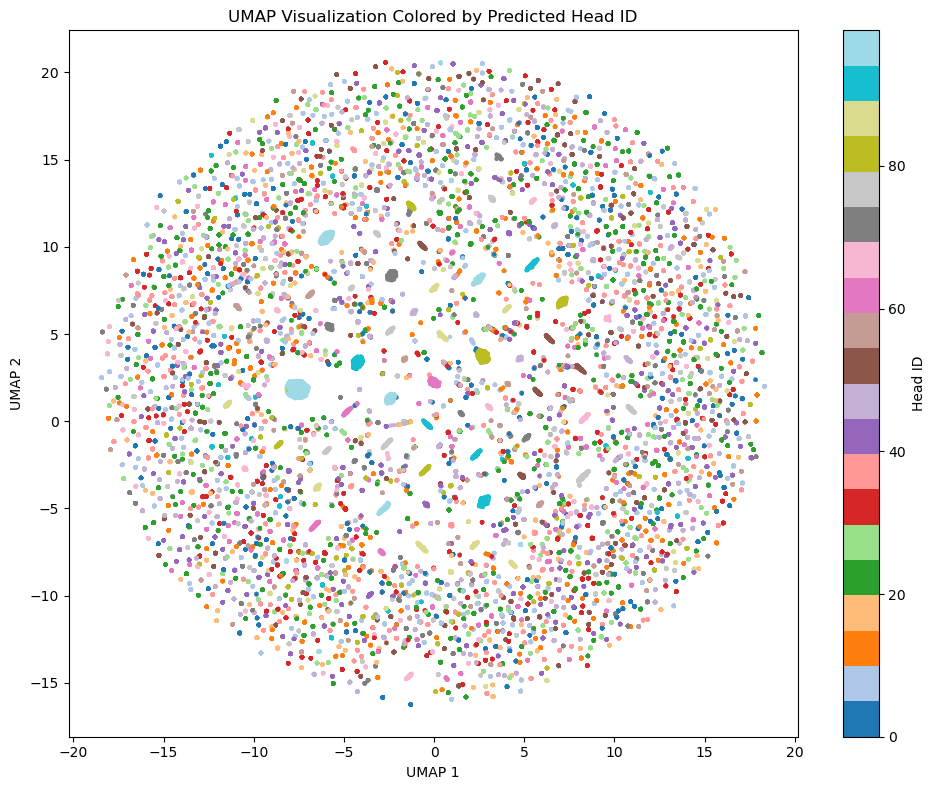

In [ ]:
# Plot using matplotlib
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=head_ids, cmap='tab20',s=10, alpha=1, edgecolors='none')
plt.colorbar(scatter, label='Head ID')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Visualization Colored by Predicted Head ID')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "UMAP_Latents_AE_MaxP.png"))
plt.show()

In [10]:
from sklearn.manifold import TSNE
# === t-SNE ===
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate='auto')
z_tsne = tsne.fit_transform(latents_scaled)

Running t-SNE...


In [11]:
from sklearn.decomposition import PCA

# === PCA ===
print("Running PCA...")
pca = PCA(n_components=2)
z_pca = pca.fit_transform(latents_scaled)

Running PCA...


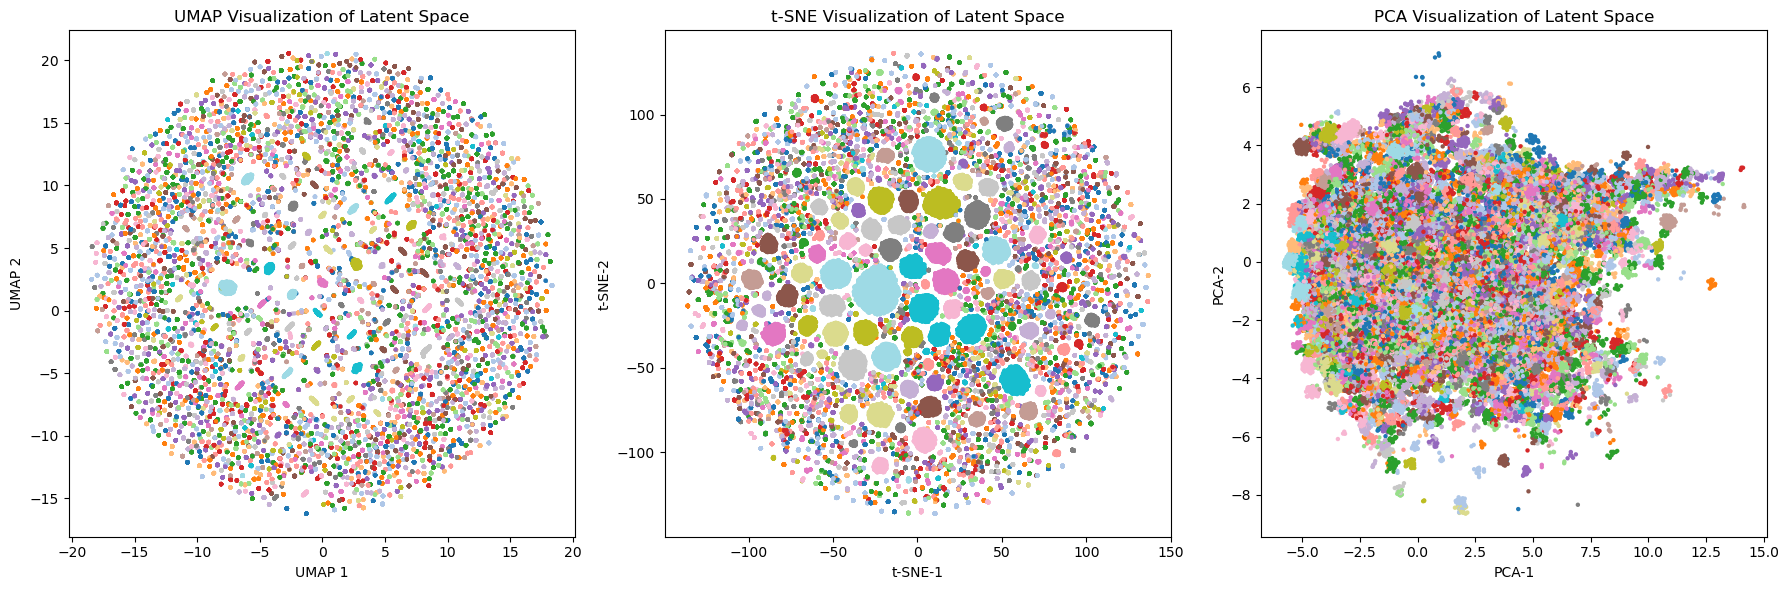

In [ ]:
# === Plot ===
plt.figure(figsize=(18,6))  

plt.subplot(1, 3, 1)
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=head_ids, cmap='tab20',s=10, alpha=1, edgecolors='none')
#plt.colorbar(scatter, label='Head ID')
plt.title("UMAP Visualization of Latent Space")
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.subplot(1, 3, 2)
scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=head_ids, cmap='tab20', s=10, alpha=1, edgecolors='none')
#plt.colorbar(scatter, label='Head ID')
plt.title("t-SNE Visualization of Latent Space")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")

plt.subplot(1, 3, 3)
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=head_ids, cmap='tab20', s=10, alpha=1, edgecolors='none')
#plt.colorbar(scatter, label='Head ID')
plt.title("PCA Visualization of Latent Space")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "UMAP_TSNE_PCA_MaxP_Plot_newOrder.png"))
plt.show()

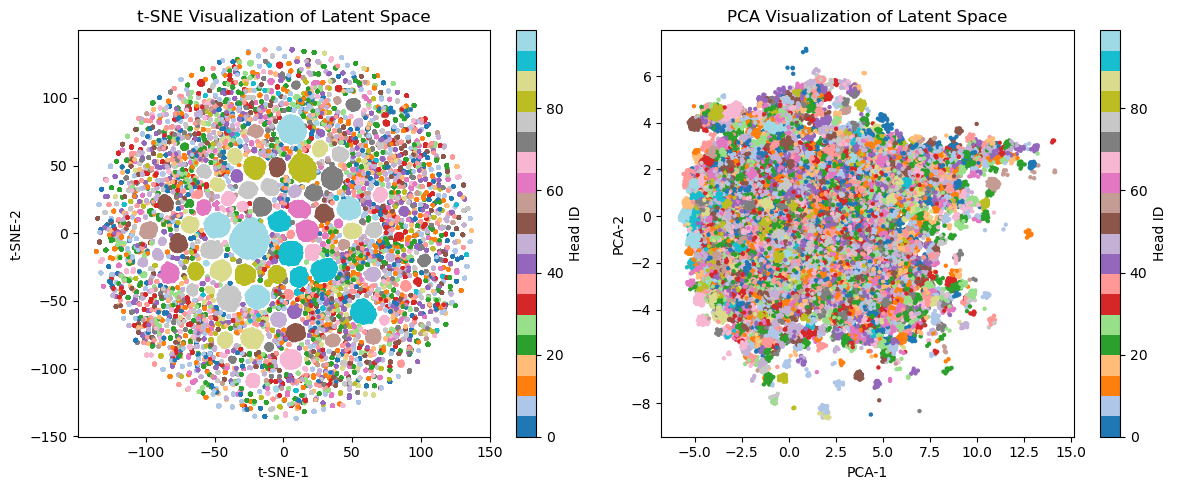

In [ ]:
# === Plot ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=head_ids, cmap='tab20',s=10, alpha=1, edgecolors='none')
plt.colorbar(scatter, label='Head ID')
plt.title("t-SNE Visualization of Latent Space")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")

plt.subplot(1, 2, 2)
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=head_ids, cmap='tab20',s=10, alpha=1, edgecolors='none')
plt.colorbar(scatter, label='Head ID')
plt.title("PCA Visualization of Latent Space")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "TSNE_PCA_Plots_AE_MaxP.png"))
plt.show()

## Clustering (on original, normalized data - then visualize in 2D)

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Perform K-means clustering on the original high-dimensional data
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
clusters = kmeans.fit_predict(latents_scaled)

# Calculate silhouette score using a sample for efficiency
sample_size = 20000  # Adjust based on your memory
if len(latents_scaled) > sample_size:
    # Randomly sample indices
    sample_indices = np.random.choice(len(latents_scaled), sample_size, replace=False)
    sample_data = latents_scaled[sample_indices]
    sample_clusters = clusters[sample_indices]
    silhouette_avg = silhouette_score(sample_data, sample_clusters)
    print(f"Sample silhouette score (n={sample_size}): {silhouette_avg:.3f}")
else:
    silhouette_avg = silhouette_score(latents_scaled, clusters)
    print(f"Full silhouette score: {silhouette_avg:.3f}")

Sample silhouette score (n=20000): 0.228


Silhouette Score of < 0.5 indicates weak clustering

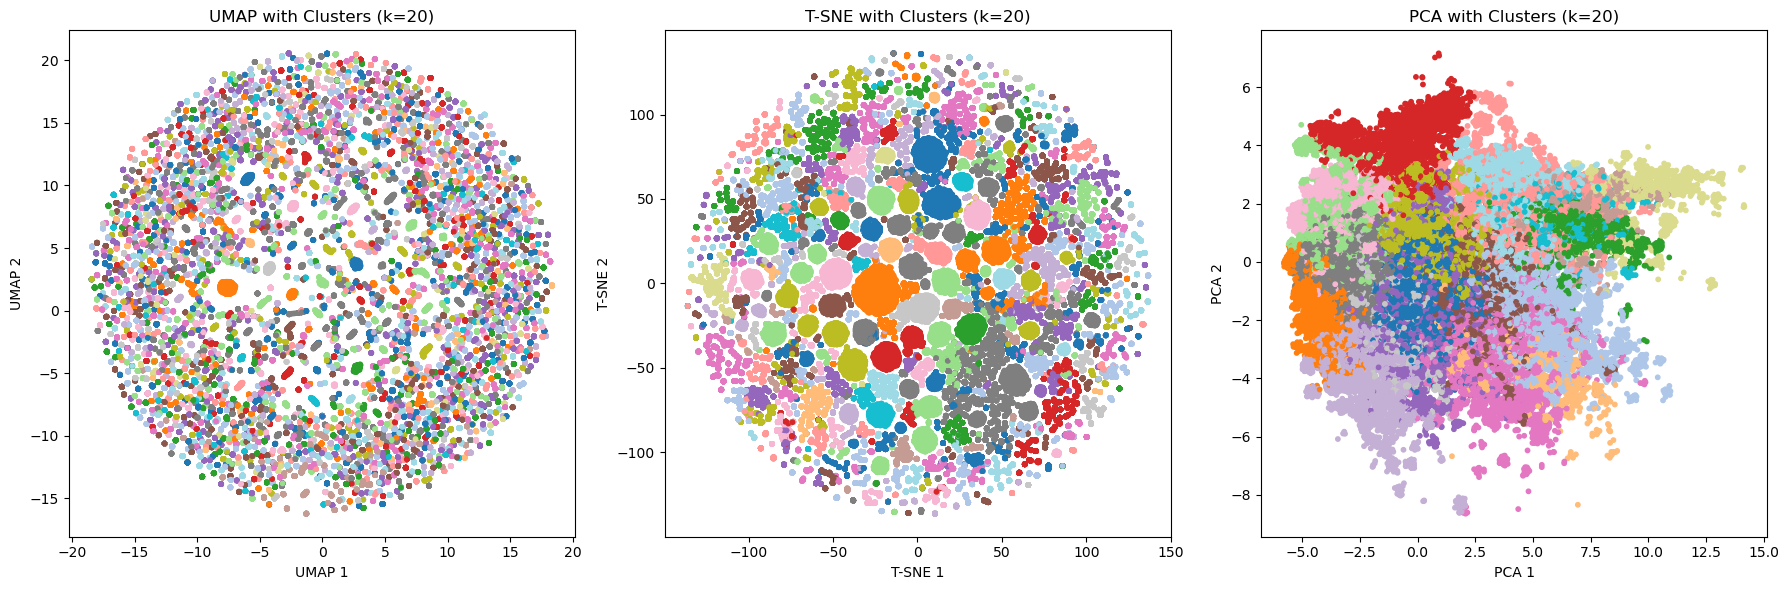

In [ ]:
# Create side-by-side visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# UMAP Clusters
scatter1 = axes[0].scatter(latents_2d[:, 0], latents_2d[:, 1], c=clusters, cmap='tab20', alpha=1, s=10)
axes[0].set_title(f'UMAP with Clusters (k=20)')
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')

# T-SNE Clusters
scatter2 = axes[1].scatter(z_tsne[:, 0], z_tsne[:, 1], c=clusters, cmap='tab20', alpha=1, s=10)
axes[1].set_title(f'T-SNE with Clusters (k=20)')
axes[1].set_xlabel('T-SNE 1')
axes[1].set_ylabel('T-SNE 2')

# PCA Clusters
scatter3 = axes[2].scatter(z_pca[:, 0], z_pca[:, 1], c=clusters, cmap='tab20', alpha=1, s=10)
axes[2].set_title(f'PCA with Clusters (k=20)')
axes[2].set_xlabel('PCA 1')
axes[2].set_ylabel('PCA 2')

# Add colorbar
#plt.colorbar(scatter1, ax=axes[0], shrink=0.8)
#plt.colorbar(scatter2, ax=axes[1], shrink=0.8)
#plt.colorbar(scatter3, ax=axes[2], shrink=0.8)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "Clustering_MaxP_UMAP_TSNE_PCA_Plot.png"))
plt.show()

# Visualize Latents regarding other labels than Face-ID

### 1. Gender

In [ ]:
import pandas as pd

head_mapping_file = local_paths.HEAD_N_MAP
# Import Head Mapping File
mapping = pd.read_csv(head_mapping_file, names=["CFD_filename", "idx", "unknown", "head_nr"])

# further process the filename to match the filename in the official CFD documents
mapping['Model'] = mapping['CFD_filename'].str.split('-').str[1] + '-' + mapping['CFD_filename'].str.split('-').str[2]
mapping

# Load the CFD Data File
cfd_data = pd.read_excel(
    io=os.path.join(head_mapping_folder, "CFD/CFD_NormingData.xlsx"), 
    sheet_name="CFD U.S. Norming Data",        
    header=7,                     
)

# Find the index where the physical attributes start
phys_idx = cfd_data.columns.get_loc("LuminanceMedian")
cfd_phys = cfd_data.loc[:, ['Model'] + ['GenderSelf'] + list(cfd_data.columns[phys_idx:])]

# Now merge both dataframes using the Model column 
df_merged = pd.merge(mapping, cfd_phys, on='Model', how='inner')

# Remove columns that does not match to a head from the dataset
df = df_merged[df_merged['head_nr'] != '_']

# Extract the corresponding head index sperately
df['head_index'] = df['head_nr'].str.extract(r'Head(\d+)').astype(int)
df.head()

/tmp/ipykernel_763988/3381278773.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['head_index'] = df['head_nr'].str.extract(r'Head(\d+)').astype(int)


CFD_filename  idx unknown head_nr   Model GenderSelf  \
0  CFD-WF-001-003-N.jpg    1       y   Head1  WF-001          F   
1  CFD-WF-002-004-N.jpg    2       y   Head2  WF-002          F   
2  CFD-WF-003-003-N.jpg    3       y   Head3  WF-003          F   
3  CFD-WF-005-010-N.jpg    4       y   Head4  WF-005          F   
4  CFD-WF-006-002-N.jpg    5       y   Head5  WF-006          F   

   LuminanceMedian  NoseWidth  NoseLength  LipThickness  ...  UpperHeadLength  \
0            158.0      188.0       251.0          65.0  ...         0.400948   
1            176.0      175.0       205.0          74.0  ...         0.379065   
2            163.5      179.0       250.0          80.0  ...         0.375596   
3            160.5      199.0       275.0         101.0  ...         0.414978   
4            162.0      179.0       267.0          92.0  ...         0.385754   

   MidfaceLength  ChinLength  ForeheadHeight  CheekboneHeight  \
0       0.348578    0.184360        0.360190         0.409479   
1       0.313770    0.214939        0.285315         0.434197   
2       0.351525    0.192088        0.319352         0.436368   
3       0.322687    0.173568        0.312335         0.403524   
4       0.342044    0.162812        0.338113         0.405643   

   CheekboneProminence  FaceRoundness     fWHR2  RaterN  head_index  
0             0.122275       0.513744  1.781532    99.0           1  
1             0.075203       0.634146  2.197260    94.0           2  
2             0.071973       0.591992  1.852113    91.0           3  
3             0.112335       0.497797  1.885305    89.0           4  
4             0.112396       0.503238  1.759637    95.0           5  

[5 rows x 68 columns]

In [10]:
# merge meta df and physical attributes df
meta_extended = meta.merge(df, on="head_index", how="left")
meta_extended.head()

heatmap_file  dataset_idx  head1  head2  head3  \
0  triplet122910_pred_head037.npy       122910     37     55     76   
1   triplet83384_pred_head021.npy        83384     21     32     71   
2  triplet106536_pred_head082.npy       106536     29     70     82   
3   triplet90575_pred_head095.npy        90575     23     58     95   
4  triplet160194_pred_head095.npy       160194     78     80     95   

   gt_odd_head  model_pred  human_choice_index  correct  head_index  ...  \
0           37           0                   0        1          37  ...   
1           21           0                   0        1          21  ...   
2           82           2                   2        1          82  ...   
3           95           2                   2        1          95  ...   
4           95           2                   2        1          95  ...   

    EyeSize  UpperHeadLength MidfaceLength ChinLength ForeheadHeight  \
0  0.047629         0.403674      0.294532   0.229816       0.336395   
1  0.062471         0.401127      0.348755   0.152654       0.312588   
2  0.056094         0.391041      0.313963   0.181195       0.312954   
3  0.049084         0.354018      0.335453   0.207019       0.284334   
4  0.049084         0.354018      0.335453   0.207019       0.284334   

  CheekboneHeight  CheekboneProminence  FaceRoundness     fWHR2  RaterN  
0        0.364161           127.000000       0.421615  2.046154    28.0  
1        0.404415             0.128699       0.453734  1.603949    92.0  
2        0.373890           169.000000       0.402744  1.863426    29.0  
3        0.394456            97.500000       0.581892  2.232240    27.0  
4        0.394456            97.500000       0.581892  2.232240    27.0  

[5 rows x 77 columns]

In [11]:
meta_extended["GenderSelf"] = meta_extended["GenderSelf"].fillna("Unknown")
gender = meta_extended["GenderSelf"].astype("category")
gender = gender.cat.reorder_categories(["M","Unknown", "F"])
gender_codes = gender.cat.codes
mapping = dict(enumerate(gender.cat.categories))
print(mapping)

{0: 'M', 1: 'Unknown', 2: 'F'}


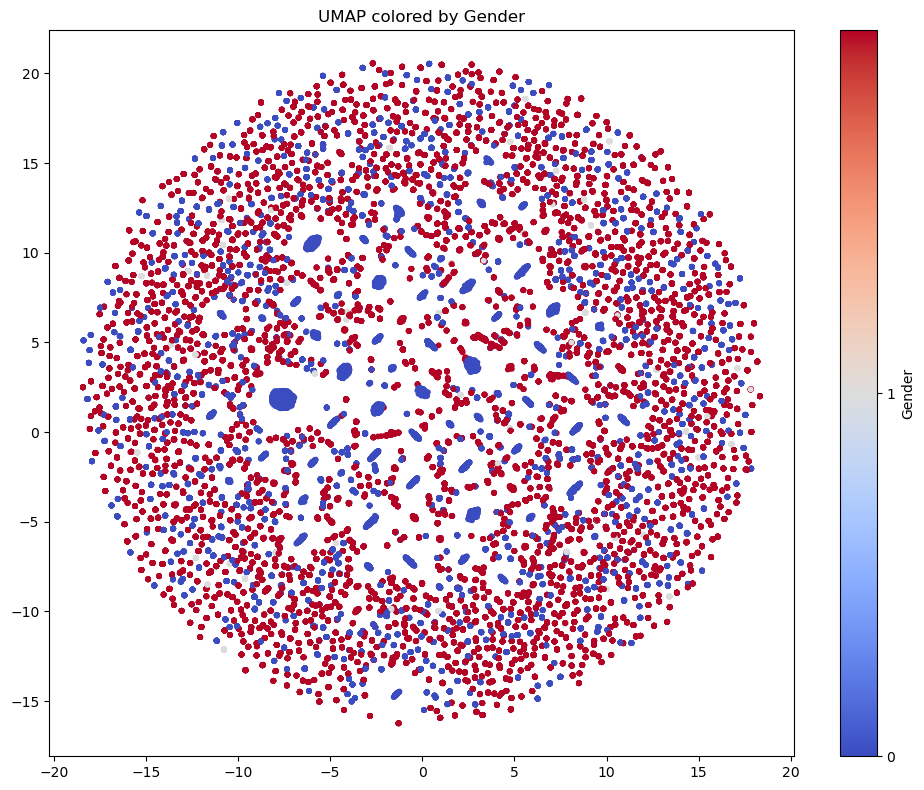

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    latents_2d[:, 0],
    latents_2d[:, 1],
    c=gender_codes,
    cmap="coolwarm", 
    s=10,
)
plt.colorbar(scatter, ticks=[0, 1], label="Gender")
plt.title("UMAP colored by Gender")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "UMAP_by_Gender_MaxP"))
plt.show()

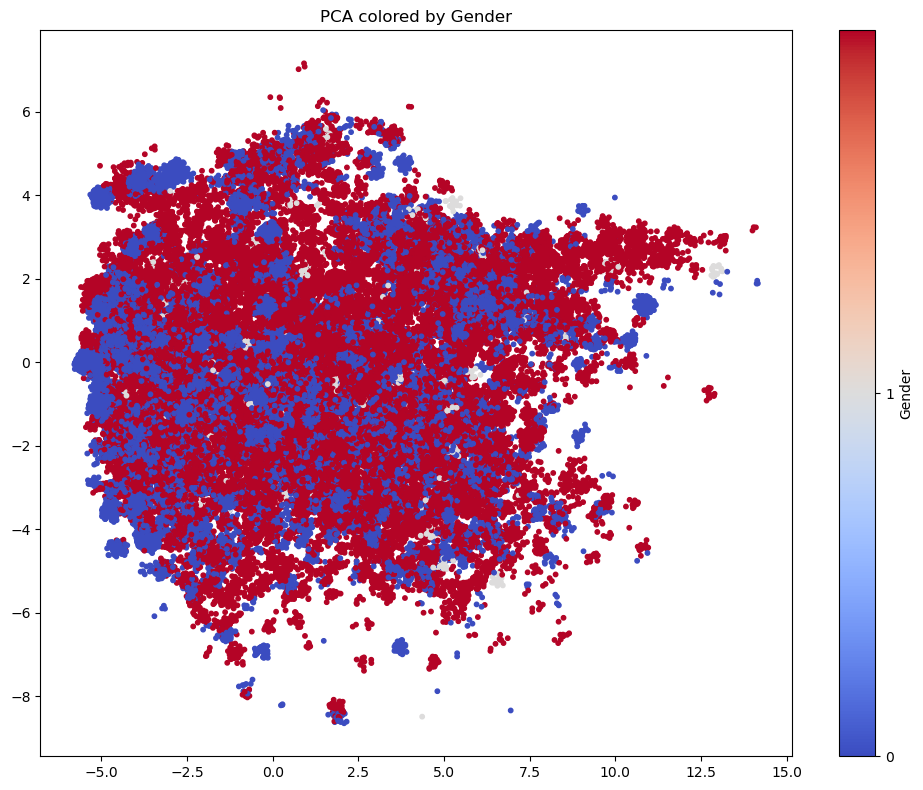

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    z_pca[:, 0], 
    z_pca[:, 1],
    c=gender_codes,
    cmap="coolwarm", 
    s=10,
)
plt.colorbar(scatter, ticks=[0, 1], label="Gender")
plt.title("PCA colored by Gender")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "PCA_by_Gender_MaxP"))
plt.show()

## Nose Shape

In [17]:
nose_width = meta_extended["NoseWidth"].astype(float)
nose_length = meta_extended["NoseLength"].astype(float)

nose_shape = nose_width / nose_length

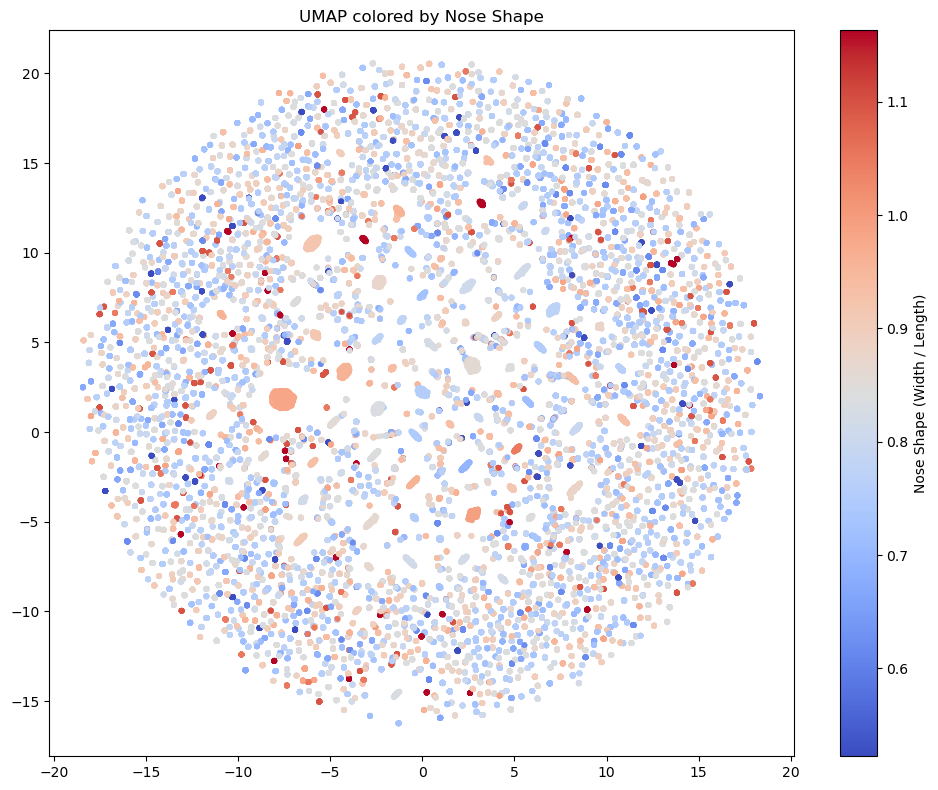

In [ ]:
plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    latents_2d[:, 0],
    latents_2d[:, 1],
    c=nose_shape,
    cmap="coolwarm",
    s=10,
)

plt.colorbar(scatter, label="Nose Shape (Width / Length)")
plt.title("UMAP colored by Nose Shape")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "UMAP_by_NoseShape_MaxP"))
plt.show()

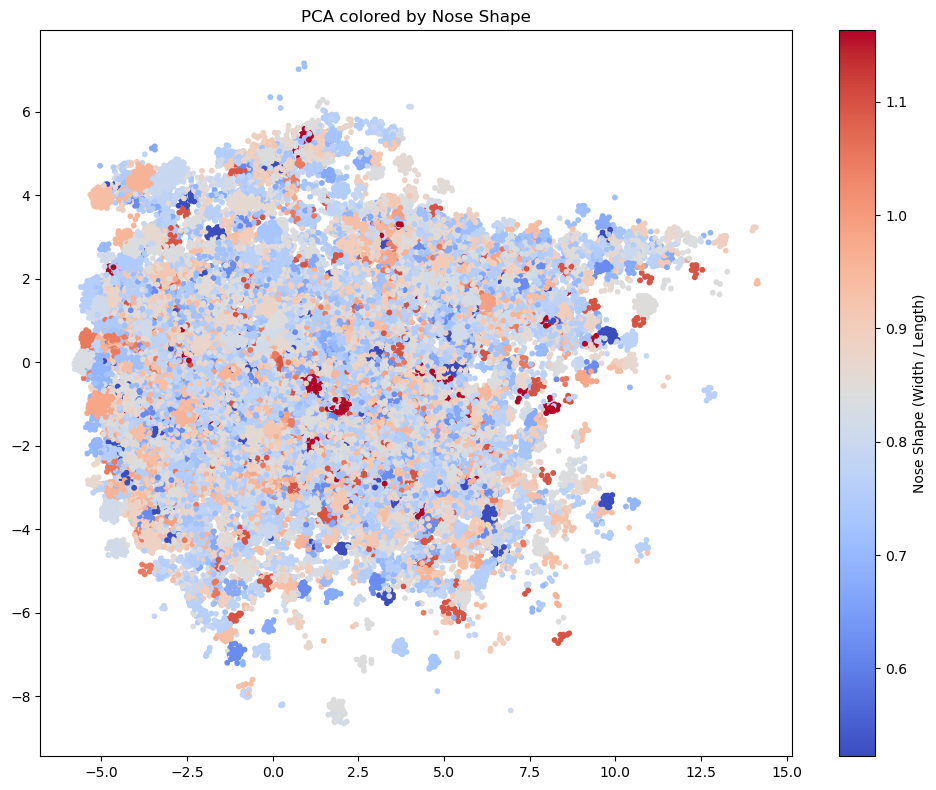

In [ ]:
plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    z_pca[:, 0], 
    z_pca[:, 1],
    c=nose_shape,
    cmap="coolwarm",
    s=10,
)

plt.colorbar(scatter, label="Nose Shape (Width / Length)")
plt.title("PCA colored by Nose Shape")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "PCA_by_NoseShape_MaxP"))
plt.show()

## Face Ration

In [21]:
face_length = meta_extended["UpperFaceLength2"].astype(float)
face_width = meta_extended["FaceWidthCheeks"].astype(float)

face_shape = face_length/face_width

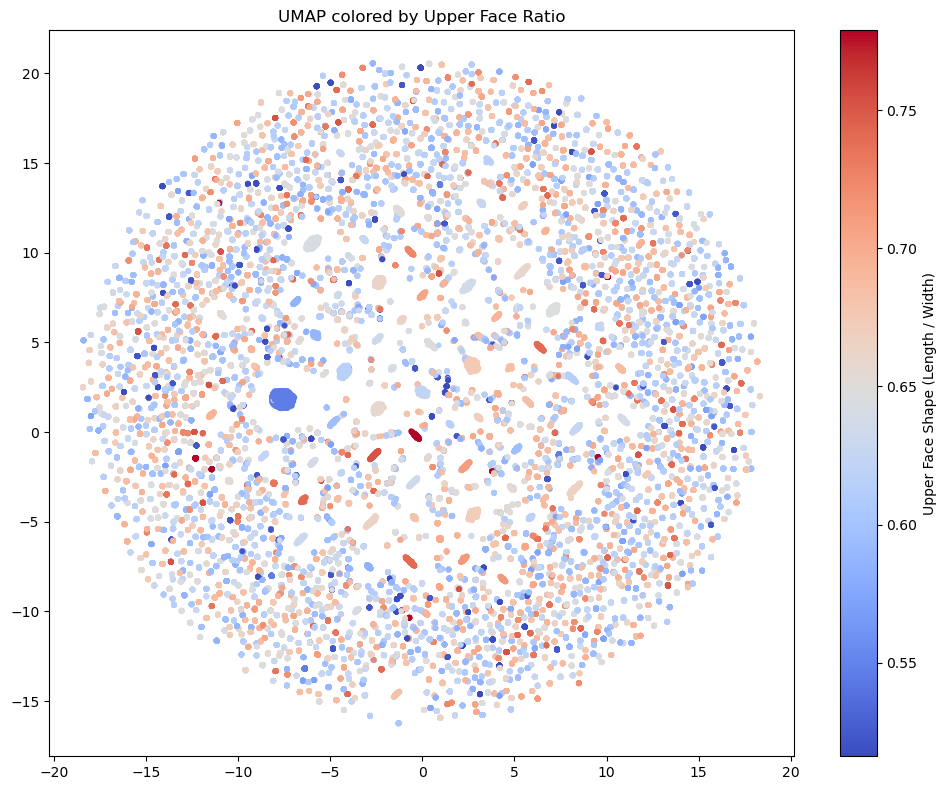

In [ ]:
plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    latents_2d[:, 0],
    latents_2d[:, 1],
    c=face_shape,
    cmap="coolwarm",
    s=10,
)

plt.colorbar(scatter, label="Upper Face Shape (Length / Width)")
plt.title("UMAP colored by Upper Face Ratio")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "UMAP_by_FaceRatio_MaxP"))
plt.show()

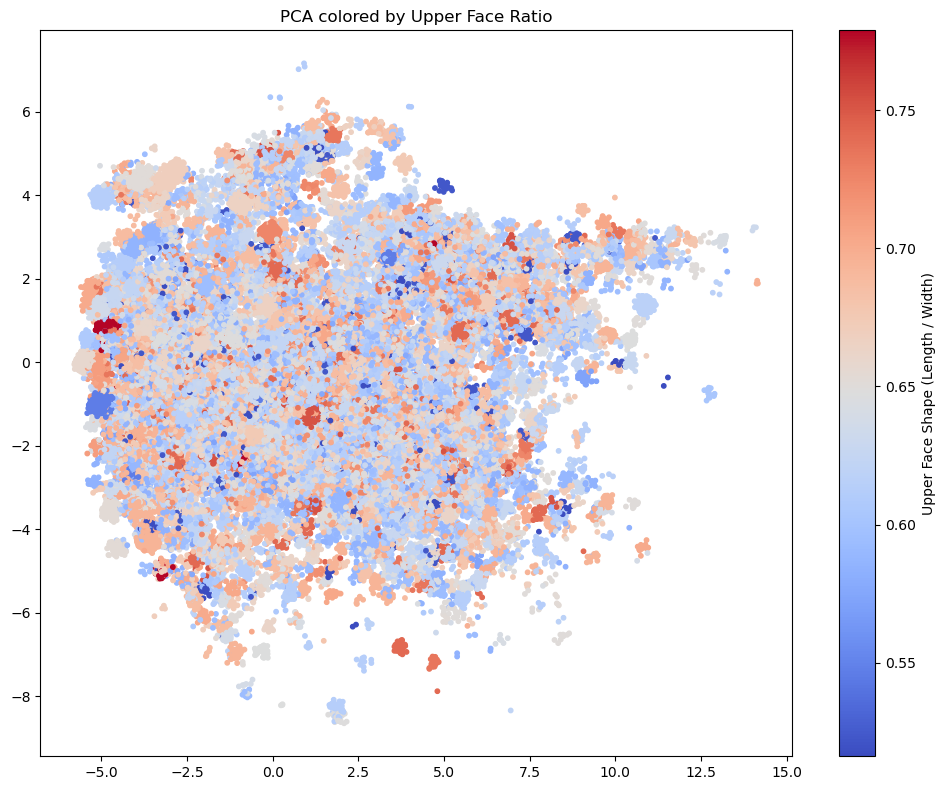

In [ ]:
plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    z_pca[:, 0], 
    z_pca[:, 1],
    c=face_shape,
    cmap="coolwarm",
    s=10,
)

plt.colorbar(scatter, label="Upper Face Shape (Length / Width)")
plt.title("PCA colored by Upper Face Ratio")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "PCA_by_FaceRatio_MaxP"))
plt.show()

## Upper Face Length

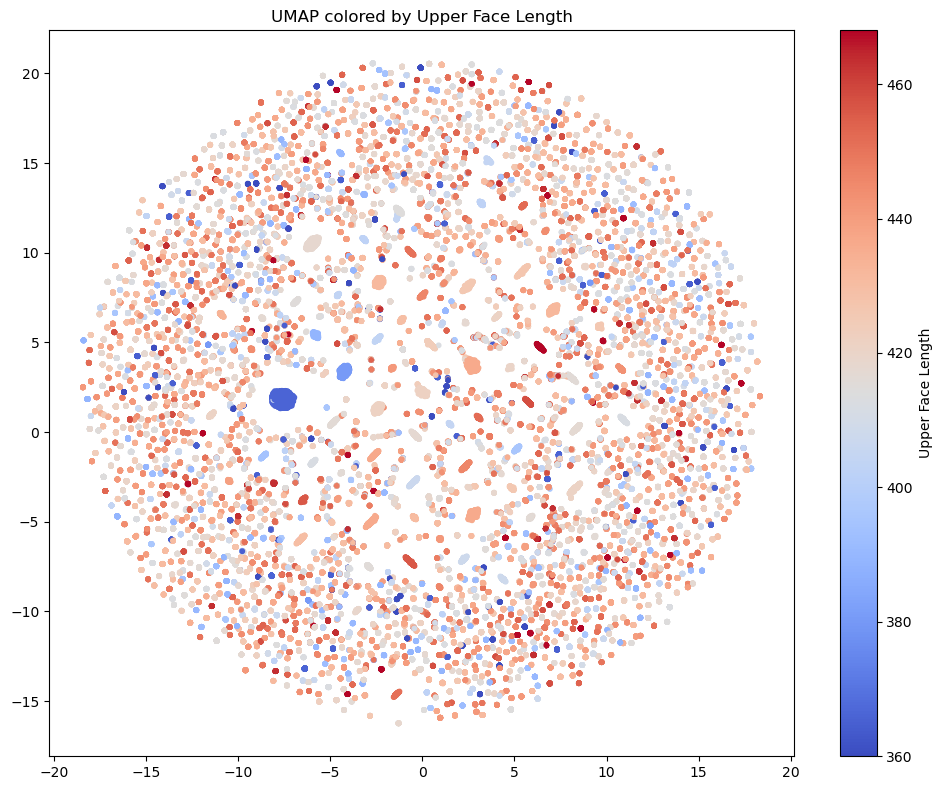

In [ ]:
face_length = meta_extended["UpperFaceLength2"].astype(float)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    latents_2d[:, 0],
    latents_2d[:, 1],
    c=face_length,
    cmap="coolwarm",
    s=10,
)

plt.colorbar(scatter, label="Upper Face Length")
plt.title("UMAP colored by Upper Face Length")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "UMAP_by_FaceLength_MaxP"))
plt.show()


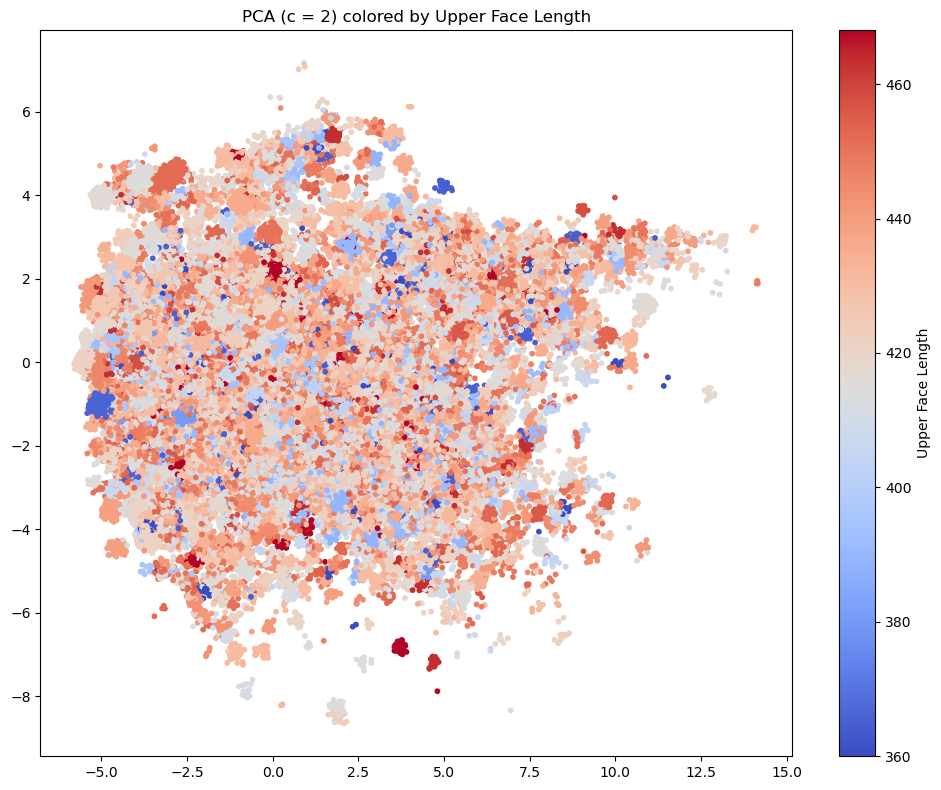

In [ ]:
face_length = meta_extended["UpperFaceLength2"].astype(float)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    z_pca[:, 0], 
    z_pca[:, 1],
    c=face_length,
    cmap="coolwarm",
    s=10,
)

plt.colorbar(scatter, label="Upper Face Length")
plt.title("PCA (c = 2) colored by Upper Face Length")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "PCA_by_FaceLength_MaxP"))
plt.show()
